In [1]:
%cd ..

/home/quasar/GitHub/TradeForecast


/home/quasar/GitHub/TradeForecast/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from tradeforecast import Scrapper

ticker = 'AAPL'
scrapper = Scrapper(ticker)

exported_fname = scrapper.export_historic_data(interval='1d', period='max')

[*********************100%***********************]  1 of 1 completed


In [3]:
from tradeforecast.augmentation import DataEntryPoint, RNNDataset, train_test_split
import polars as pl

data_entry = DataEntryPoint(exported_fname[ticker])

lf = data_entry.data.drop_nulls()
lf.collect()

Datetime,Close,High,Low,Open,Volume
"datetime[μs, EST]",f64,f64,f64,f64,i64
1980-12-11 19:00:00 EST,0.128348,0.128906,0.128348,0.128348,469033600
1980-12-14 19:00:00 EST,0.121652,0.12221,0.121652,0.12221,175884800
1980-12-15 19:00:00 EST,0.112723,0.113281,0.112723,0.113281,105728000
1980-12-16 19:00:00 EST,0.115513,0.116071,0.115513,0.115513,86441600
1980-12-17 19:00:00 EST,0.118862,0.11942,0.118862,0.118862,73449600
…,…,…,…,…,…
2024-11-10 19:00:00 EST,224.229996,225.699997,221.5,225.0,42005600
2024-11-11 19:00:00 EST,224.229996,225.589996,223.360001,224.550003,40398300
2024-11-12 19:00:00 EST,225.119995,226.649994,222.759995,224.009995,48566200


In [4]:
from torch.utils.data import DataLoader

dataset_kwargs = {'lf': lf,
                 'non_temporal': data_entry.non_temporal,
                 'temporal': data_entry.temporal,
                 'target': 'Close',
                 'look_back_len': 30,
                 'forecast_len': 5}

rnn_dataset = RNNDataset(**dataset_kwargs)

train_dataset, test_dataset = train_test_split(rnn_dataset, 0.05)
print(len(rnn_dataset), len(train_dataset), len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

11010 10460 550


In [5]:
from tradeforecast import LSTM
from torch import nn, optim

lstm_kwargs = {'input_size': len(rnn_dataset.features),
              'hidden_size': 32,
              'n_LSTM': 4,
              'bidirectional': True,
              'fc_out_size':[],
              'output_size': rnn_dataset.forecast_len,
              'dropout': 0}

lstm_model = LSTM(**lstm_kwargs)
print(f"The device is set to ---> '{lstm_model.device}'")

The device is set to ---> 'cuda'


In [6]:
lstm_model.train_model(nn.MSELoss, optim.SGD, 1500, train_loader, 0.001)

Epoch: [1/1500]; Loss: 3.368738
Epoch: [2/1500]; Loss: 3.307308
Epoch: [3/1500]; Loss: 3.251703
Epoch: [4/1500]; Loss: 3.201152
Epoch: [5/1500]; Loss: 3.155041
Epoch: [6/1500]; Loss: 3.112871
Epoch: [7/1500]; Loss: 3.074230
Epoch: [8/1500]; Loss: 3.038773
Epoch: [9/1500]; Loss: 3.006207
Epoch: [10/1500]; Loss: 2.976278
Epoch: [11/1500]; Loss: 2.948766
Epoch: [12/1500]; Loss: 2.923476
Epoch: [13/1500]; Loss: 2.900232
Epoch: [14/1500]; Loss: 2.878876
Epoch: [15/1500]; Loss: 2.859261
Epoch: [16/1500]; Loss: 2.841254
Epoch: [17/1500]; Loss: 2.824728
Epoch: [18/1500]; Loss: 2.809562
Epoch: [19/1500]; Loss: 2.795644
Epoch: [20/1500]; Loss: 2.782864
Epoch: [21/1500]; Loss: 2.771120
Epoch: [22/1500]; Loss: 2.760309
Epoch: [23/1500]; Loss: 2.750338
Epoch: [24/1500]; Loss: 2.741113
Epoch: [25/1500]; Loss: 2.732545
Epoch: [26/1500]; Loss: 2.724549
Epoch: [27/1500]; Loss: 2.717042
Epoch: [28/1500]; Loss: 2.709944
Epoch: [29/1500]; Loss: 2.703178
Epoch: [30/1500]; Loss: 2.696669
Epoch: [31/1500]; L

In [7]:
model_fname = lstm_model.save_model_state(ticker_interval='AAPL_1d_base')
model_fname

'AAPL_1d_base_biLSTM(85413,5,5)-cuda.pth'

In [8]:
from sklearn.metrics import mean_absolute_percentage_error
from torch import Tensor

y: Tensor; y_preds: Tensor
y, y_preds = lstm_model.test_model(test_loader)

y_arr, y_preds_arr = y.cpu().numpy(), y_preds.cpu().numpy()
print(y_arr.shape, y_preds_arr.shape)

y_arr = rnn_dataset.inverse_transform(y_arr)
y_preds_arr = rnn_dataset.inverse_transform(y_preds_arr)
mean_absolute_percentage_error(y_arr, y_preds_arr)

(550, 5) (550, 5)


np.float64(0.14824200752164116)

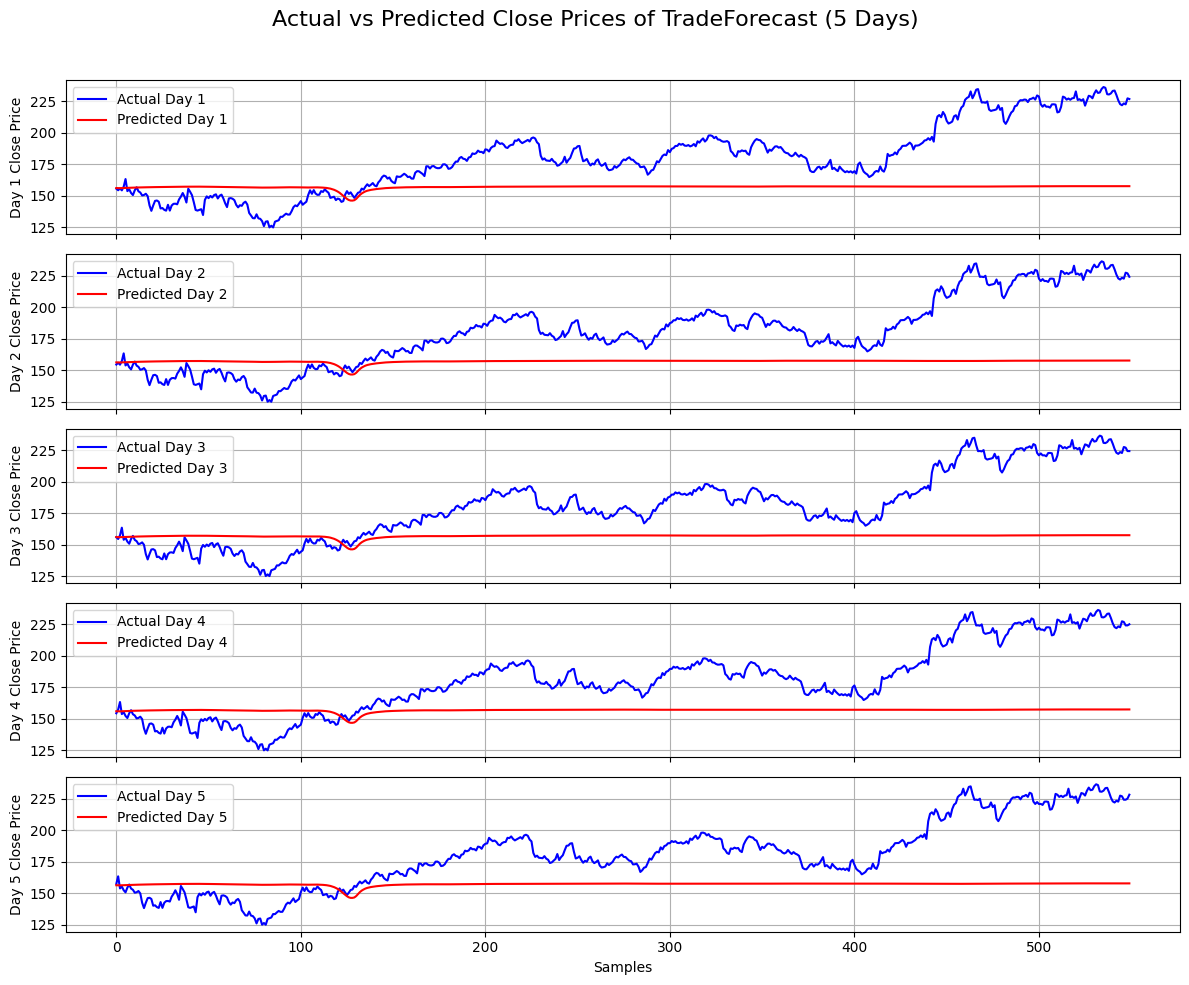

In [9]:
from tradeforecast.viz import plot_rnn_forecasts

plot_rnn_forecasts(y_arr, y_preds_arr)